## DPC Policy train

## 01. Prepare packages

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import pickle
from pickle import dump

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from scipy.optimize import minimize, Bounds
from scipy.stats import qmc
from torchmin import minimize as pytorch_minimize

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import os
print(os.listdir())

# import functions
import importlib
import Policy
importlib.reload(Policy)

from Policy import DPC_PolicyTransformer, DPC_loss
from TiDE import TideModule, quantile_loss, TiDE_forward

if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")
    

['Train.ipynb', 'Execute.ipynb', 'nominal_params_w10_mid_noise_stable_final.pkl', 'policy_model_3L_64H.pth', 'nominal_params_w10_mid_noise_stable_final.pth', '__pycache__', 'TiDE.py', 'x_and_u_and_c_case3.pickle', 'Policy.py']
cuda is available


## 02. System identification

In [66]:
t_tot = 50000
init_zero = 1000
def f_ss(x0,u):
    A = np.array([[0.3,0.1], [0.1, 0.2]])
    B = np.array([[0.5],[1.0]])
    mu = np.array([[0],[0]])*0
    w = np.array([[0.05],[0.1]])
    x = A@x0+B*u + np.random.normal(mu,w,size=(2,1))
    return x

def f_ss_multistep(x0,u):
    step = len(u)
    output = np.zeros([2,step])
    for i in range(step):
        x_next = f_ss(x0,u[i])
        x0 = np.copy(x_next)
        output[:,i] = x_next.reshape(-1)
    return output

tspan = [0, t_tot]
x0 = np.array([[0],[0]])
print(x0.shape)

(2, 1)


## 03-1. Data generation (Reference)

In [67]:
import numpy as np
import random
from scipy.special import expit 

def generate_u_seq():
    total_steps = t_tot * 2 

    init_zeros = np.zeros(1000)
    step_seq = []
    while len(step_seq) < t_tot:
        value = np.random.uniform(-5, 5)  
        duration = random.randint(5, 20) 
        step_seq.extend([value] * duration)
    step_seq = np.array(step_seq[:t_tot])  

    sin_seq = np.array([])
    while len(sin_seq) < t_tot:
        period = random.randint(10, 32) 
        duration = random.randint(10, 20)  
        x = np.linspace(0, 2 * np.pi, period)  
        amplitude = np.random.uniform(-5, 5) 
        segment = amplitude * np.sin(x)[:duration]  
        sin_seq = np.append(sin_seq, segment)
    sin_seq = sin_seq[:t_tot]
    u_seq = np.concatenate([init_zeros, step_seq, sin_seq])

    return u_seq

u_seq = generate_u_seq()
print(u_seq.shape)  

(101000,)


In [68]:
def dynamic_data_generator(x0, u_seq):
    step = len(u_seq)
    output = np.zeros([x0.shape[0], step])

    for i in range(step):
        u_max = 3 + 2 * np.random.random(1)
        u_min = -u_max
        x_next = f_ss(x0, u_seq[i]) 
        x0 = np.copy(x_next)

        output[:, i] = x_next.reshape(-1)

    return output, u_seq 
x_output, u_seq_new = dynamic_data_generator(x0,u_seq)

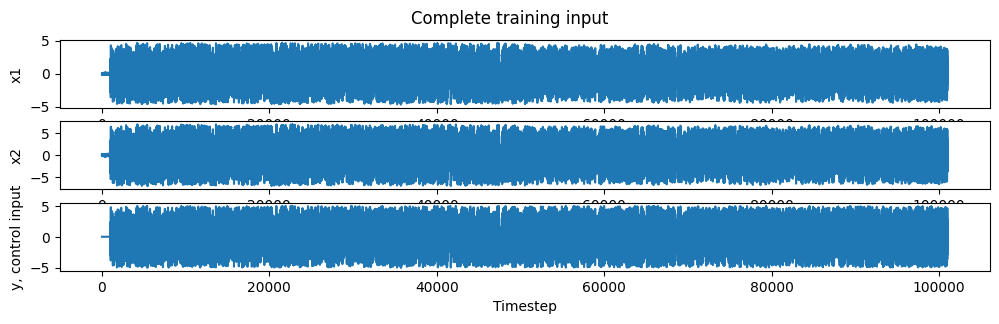

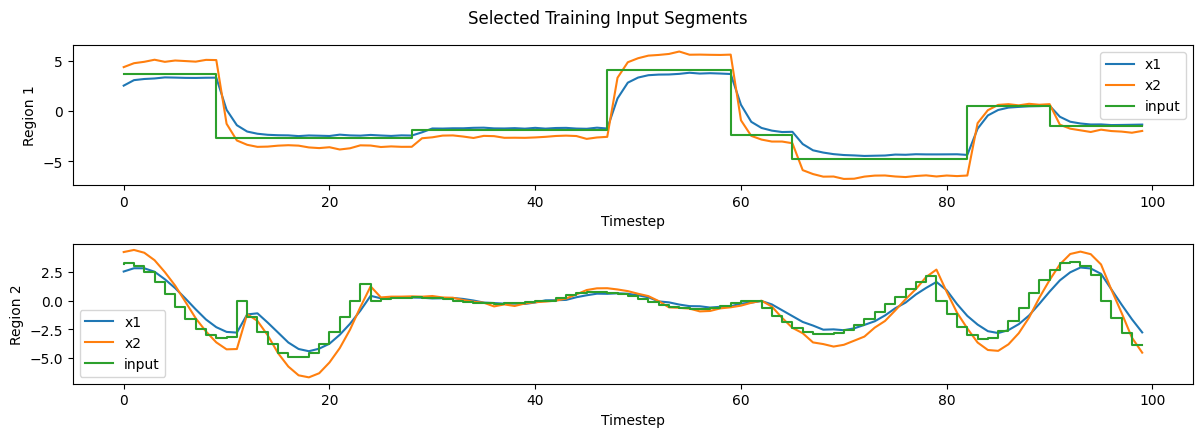

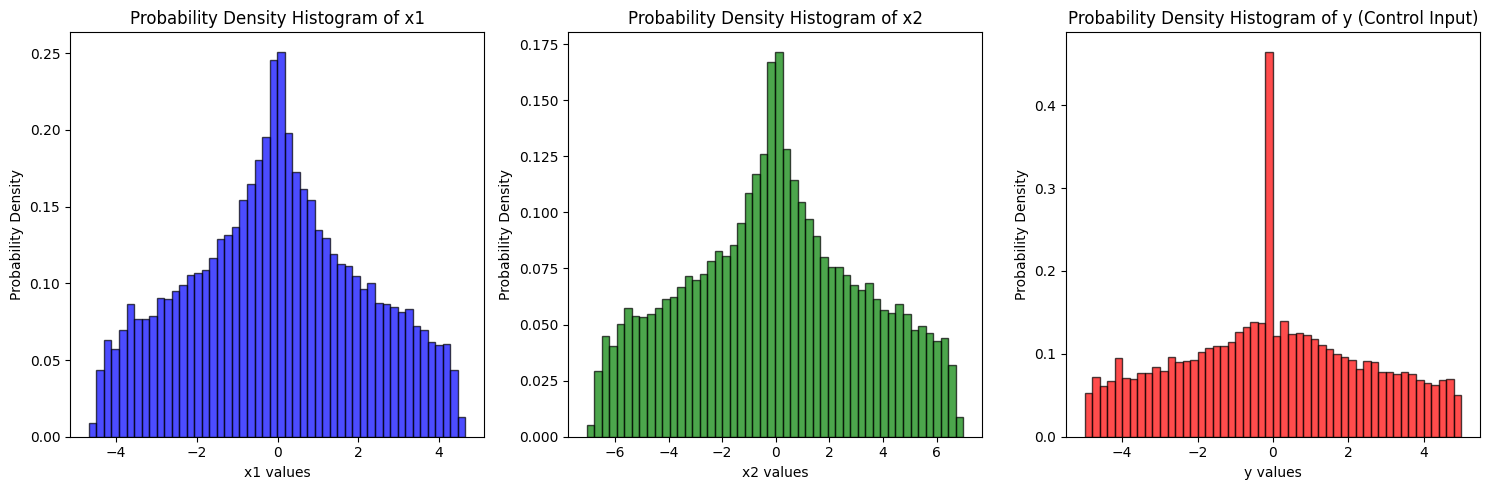

In [69]:
plt.figure(figsize=(12,3))
plt.suptitle("Complete training input")
plt.subplot(3,1,1)

plt.plot(x_output[0,:], label="x1")
plt.xlabel("x1, system response")
plt.ylabel("x1")
plt.subplot(3,1,2)

plt.plot(x_output[1,:],label="x2")
plt.xlabel("x2, system response")
plt.ylabel("x2")
plt.subplot(3,1,3)
plt.plot(u_seq, drawstyle='steps',label="input")
plt.xlabel("Timestep")
plt.ylabel("y, control input")

plt.show()

mm_list = [2000, t_tot + 2000] 
window_size = 100

plt.figure(figsize=(12, 6)) 

for idx, mm in enumerate(mm_list, 1):
    plt.subplot(3, 1, idx)
    plt.plot(x_output[0, mm:mm+window_size], label="x1")
    plt.plot(x_output[1, mm:mm+window_size], label="x2")
    plt.plot(u_seq[mm:mm+window_size], drawstyle='steps', label="input")

    plt.xlabel("Timestep")
    plt.ylabel(f"Region {idx}")  
    plt.legend()

plt.suptitle("Selected Training Input Segments")
plt.tight_layout()  
plt.show()

x1 = x_output[0, :]
x2 = x_output[1, :]
y = u_seq_new.flatten()  

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(x1, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title("Probability Density Histogram of x1")
axes[0].set_xlabel("x1 values")
axes[0].set_ylabel("Probability Density")

axes[1].hist(x2, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title("Probability Density Histogram of x2")
axes[1].set_xlabel("x2 values")
axes[1].set_ylabel("Probability Density")

axes[2].hist(y, bins=50, density=True, alpha=0.7, color='red', edgecolor='black')
axes[2].set_title("Probability Density Histogram of y (Control Input)")
axes[2].set_xlabel("y values")
axes[2].set_ylabel("Probability Density")

plt.tight_layout()
plt.show()

x = x_output
u = u_seq_new.reshape(1,-1)

## 03-2. Data generation (Constraint)

In [70]:
def generate_constraint_seq():
    init_fives = np.full(1000, 4)  
    step_seq = []
    while len(step_seq) < t_tot:
        value = np.random.uniform(2, 5) 
        duration = random.randint(20, 50) 
        step_seq.extend([value] * duration)
    step_seq = np.array(step_seq[:t_tot]) 

    sin_seq = np.array([])
    while len(sin_seq) < t_tot:
        period = random.randint(20, 50) 
        duration = random.randint(20, 50)  
        x = np.linspace(0, 2 * np.pi, period) 
        amplitude = np.random.uniform(0.5, 1) 
        center = np.random.uniform(3.5-0.5, 3.5+0.5)  
        segment = center + amplitude * np.sin(x)[:duration]  
        sin_seq = np.append(sin_seq, segment)
    sin_seq = sin_seq[:t_tot]  
    constraint_seq = np.concatenate([init_fives, step_seq, sin_seq])

    return constraint_seq

constraint_seq = generate_constraint_seq()
constraint_seq_2 = constraint_seq.reshape(1, -1)
c = np.vstack((-constraint_seq_2, constraint_seq_2))
print(c.shape)

(2, 101000)


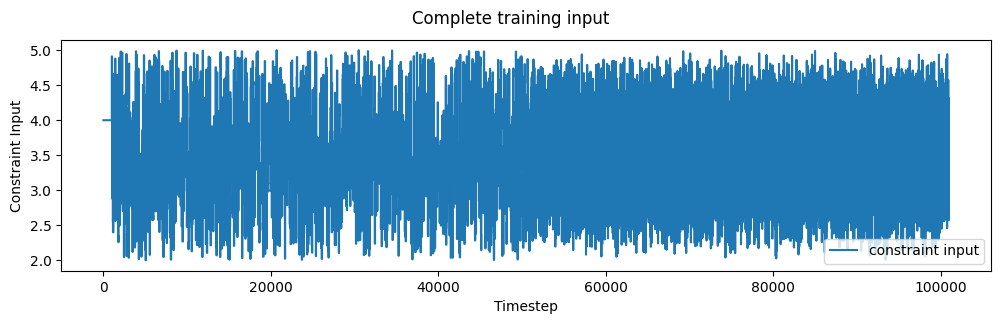

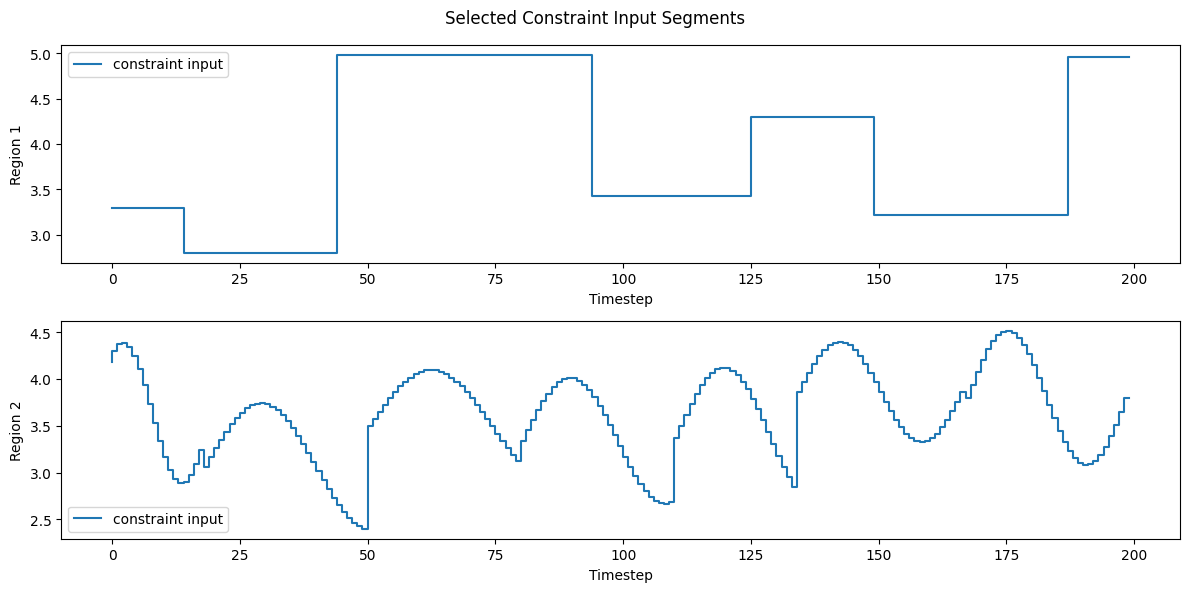

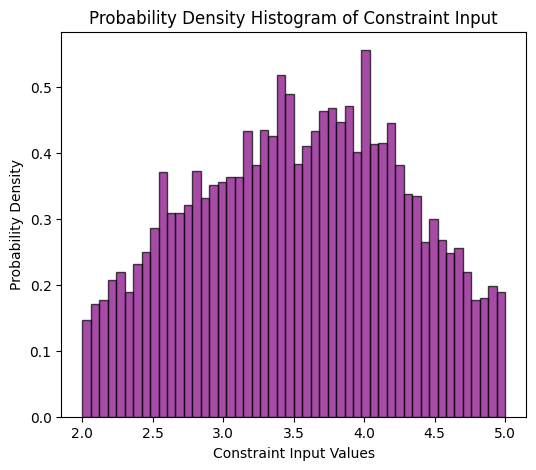

In [71]:
plt.figure(figsize=(12,3))
plt.suptitle("Complete training input")

plt.plot(constraint_seq, drawstyle='steps', label="constraint input")
plt.xlabel("Timestep")
plt.ylabel("Constraint Input")
plt.legend()
plt.show()

mm_list = [2000, t_tot + 2000]
window_size = 200

plt.figure(figsize=(12, 6))

for idx, mm in enumerate(mm_list, 1):
    plt.subplot(2, 1, idx)
    plt.plot(constraint_seq[mm:mm+window_size], drawstyle='steps', label="constraint input")
    plt.xlabel("Timestep")
    plt.ylabel(f"Region {idx}")
    plt.legend()

plt.suptitle("Selected Constraint Input Segments")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(constraint_seq, bins=50, density=True, alpha=0.7, color='purple', edgecolor='black')
ax.set_title("Probability Density Histogram of Constraint Input")
ax.set_xlabel("Constraint Input Values")
ax.set_ylabel("Probability Density")

plt.show()

In [72]:
import torch
import numpy as np

num_trials = 1000
sample_size = 1000 

device = "cuda" if torch.cuda.is_available() else "cpu"
difference_results = torch.zeros(num_trials, sample_size, device=device)
comparison_results = torch.zeros(num_trials, sample_size, device=device)  

x2 = torch.as_tensor(x2, dtype=torch.float32, device=device)
constraint_seq = torch.as_tensor(constraint_seq, dtype=torch.float32, device=device)

for i in range(num_trials):
    x2_positive = x2[x2 > 0] 
    if len(x2_positive) < sample_size:  
        raise ValueError("Not enough samples in x2_positive!")

    x2_sample = x2_positive[torch.randint(0, len(x2_positive), (sample_size,), device=device)]
    constraint_sample = constraint_seq[torch.randint(0, len(constraint_seq), (sample_size,), device=device)]
    comparison = (x2_sample > constraint_sample).to(torch.float)  
    difference = torch.clamp(x2_sample - constraint_sample, min=0) ** 2  

    comparison_results[i] = comparison
    difference_results[i] = difference

probability = comparison_results.mean().item()  
average_difference = difference_results.mean().item()  

print(f"✅ Probability of x2 > constraint_seq: {probability:.4f}")
print(f"✅ Mean squared difference (when x2 is greater than constraint_seq): {average_difference:.4f}")

✅ Probability of x2 > constraint_seq: 0.3366
✅ Mean squared difference (when x2 is greater than constraint_seq): 1.1797


## 03. Save x, u to a single pickle file

In [73]:
import pickle
data = {'x': x, 'u': u, 'c': c}

pickle_filename = 'x_and_u_and_c_case3.pickle'

with open(pickle_filename, 'wb') as f:
    pickle.dump(data, f)

print(f"Saved 'x' and 'u' arrays to {pickle_filename}")
pickle_filename = 'x_and_u_and_c_case3.pickle'

with open(pickle_filename, 'rb') as f:
    loaded_data = pickle.load(f)

x = loaded_data['x']
u = loaded_data['u']
c = loaded_data['c']

print("Loaded 'x' array shape:", x.shape)
print("Loaded 'u' array shape:", u.shape)
print("Loaded 'c' array shape:", c.shape)

Saved 'x' and 'u' arrays to x_and_u_and_c_case3.pickle
Loaded 'x' array shape: (2, 101000)
Loaded 'u' array shape: (1, 101000)
Loaded 'c' array shape: (2, 101000)


## 04. Normalize data

In [74]:
window = 10
P = 10

def normalize_array(arr, ref_arr=None):
    """
    Normalize 'arr' to the range [-1, 1] using min/max values.
    If ref_arr is provided, normalize based on ref_arr's min/max values.
    """
    if ref_arr is None:
        ref_arr = arr  

    min_val = np.min(ref_arr, axis=1, keepdims=True)  
    max_val = np.max(ref_arr, axis=1, keepdims=True)  
    diff = max_val - min_val 
    diff[diff == 0] = 1  

    print("Normalization Diff:", diff)

    normalized_arr = -1 + 2 * ((arr - min_val) / diff)
    return normalized_arr

x_normalized = normalize_array(x)
u_normalized = normalize_array(u)
c_normalized = normalize_array(c, ref_arr=np.tile(x[1, :], (2, 1)))  

print("x_normalized shape:", x_normalized.shape)
print("u_normalized shape:", u_normalized.shape)
print("c_normalized shape:", c_normalized.shape)

Xs = u_normalized.reshape(-1,1)
Ys = x_normalized.transpose()
Cs = c_normalized.transpose()

print(Xs.shape) # CONTROL
print(Ys.shape) # STATE
print(Cs.shape) # CONSTRAINTS


val_indices = [
    (1000, int(1000 + 0.1 * t_tot)),
    (t_tot + 1000, int(t_tot + 1000 + 0.1 * t_tot))
]

Xs_train = []
Ys_train = []
Cs_train = []
Xs_val = []
Ys_val = []
Cs_val = []


for i in range(Xs.shape[0]):  
    is_val = any(start <= i < end for start, end in val_indices)

    if is_val:
        Xs_val.append(Xs[i])
        Ys_val.append(Ys[i])
        Cs_val.append(Cs[i])
    else:
        Xs_train.append(Xs[i])
        Ys_train.append(Ys[i])
        Cs_train.append(Cs[i])

Xs_train = np.array(Xs_train)
Ys_train = np.array(Ys_train)
Cs_train = np.array(Cs_train)
Xs_val = np.array(Xs_val)
Ys_val = np.array(Ys_val)
Cs_val = np.array(Cs_val)

model_params = dict()
model_params["x_min"] = np.min(x, axis=1)
model_params["x_max"] = np.max(x, axis=1)
model_params["u_min"] = np.min(u, axis=1)
model_params["u_max"] = np.max(u, axis=1)
model_params["c_min"] = np.min(c, axis=1)
model_params["c_max"] = np.max(c, axis=1)
model_params["window"] = window
model_params["P"] = P

print(Xs_train.shape)
print(Xs_val.shape)

print(Cs_train.shape)
print(Cs_val.shape)

print(f"Xs (normalized u sequence) shape = {Xs.shape}, Ys (normalized x1-x2 sequence) shape = {Ys.shape}, Cs (normalized x1-x2 sequence) shape = {Cs.shape}")

Normalization Diff: [[ 9.3310929 ]
 [14.04038022]]
Normalization Diff: [[9.99386761]]
Normalization Diff: [[14.04038022]
 [14.04038022]]
x_normalized shape: (2, 101000)
u_normalized shape: (1, 101000)
c_normalized shape: (2, 101000)
(101000, 1)
(101000, 2)
(101000, 2)
(91000, 1)
(10000, 1)
(91000, 2)
(10000, 2)
Xs (normalized u sequence) shape = (101000, 1), Ys (normalized x1-x2 sequence) shape = (101000, 2), Cs (normalized x1-x2 sequence) shape = (101000, 2)


## 05. Split data

In [75]:
X_train = [] 
X_train_past = [] 
Y_train = [] 
C_train = []

for i in range(window, len(Xs_train)-P):
    X_train.append((Ys_train[i-window:i+P,:])) 
    Ys_train_add = np.copy(Xs_train[i-window:i,:]) 
    X_train_past.append(Ys_train_add) 
    Y_train.append(Xs_train[i:i+P,:]) 

X_val = []
X_val_past = []
Y_val = []

for i in range(window, len(Xs_val)-P):

    X_val.append(Ys_val[i-window:i+P,:])
    Ys_val_add = np.copy(Xs_val[i-window:i,:])
    X_val_past.append(Ys_val_add)
    Y_val.append(Xs_val[i:i+P,:])

X_train_array = np.array(X_train)
print(f' X_train shape = {X_train_array.shape}')
X_train_past = np.array(X_train_past)
print(f' X_train_past shape = {X_train_past.shape}')
Y_train_array = np.array(Y_train)
print(f' Y_train shape = {Y_train_array.shape}')


X_train_array = np.array(X_train)
X_train_orig = torch.tensor(X_train_array).type(torch.float32).to(device)                                 
X_train_past_orig = torch.tensor(np.array(X_train_past)).type(torch.float32).to(device)              
Y_train_orig = torch.tensor(np.array(Y_train)).type(torch.float32).to(device)                        

print(X_train_array.shape)
print(X_train_orig.shape)
print(X_train_past_orig.shape)
print(Y_train_orig.shape)

X_val_array = np.array(X_val)
X_val_orig = torch.tensor(X_val_array).type(torch.float32).to(device)                                 
X_val_past_orig = torch.tensor(np.array(X_val_past)).type(torch.float32).to(device)               
Y_val_orig = torch.tensor(np.array(Y_val)).type(torch.float32).to(device)                      

X_past = torch.cat([X_train_past_orig[:,:],X_train_orig[:,:window]],dim=2)
X_future_covariates = X_train_orig[:,-P:,:]

x_in = [X_past, X_future_covariates, None]
Y_in = Y_train_orig[:,:,:].to(device) 

X_past_val = torch.cat([X_val_past_orig[:,:],X_val_orig[:,:window,:]],dim=2)
X_future_covariates_val = X_val_orig[:,-P:,:]

C_fut = []
for i in range(len(Cs_train) - window - P):
    segment = Cs_train[i:i+window]  
    C_fut.append(segment)

c_fut = np.array(C_fut) 
C_fut = torch.tensor(C_fut, dtype=torch.float32).to(device) 


C_fut_val = []
for i in range(len(Cs_val) - window - P):
    segment = Cs_val[i:i+window]  
    C_fut_val.append(segment)

C_fut_val = np.array(C_fut_val)  
C_fut_val = torch.tensor(C_fut_val, dtype=torch.float32).to(device)  

x_val = [X_past_val, X_future_covariates_val[:,:,0], C_fut_val, None] 
Y_val = Y_val_orig[:,:,:].to(device)            

print(f"c_fut shape = {C_fut.shape}")  
print(f"c_fut_val shape = {C_fut_val.shape}")  


print(f"x_past shape = {X_past.shape}, x_future_covariate shape = {X_future_covariates.shape}, target shape = {Y_in.shape}")
print(f"x_past_val shape = {X_past_val.shape}, x_future_covariate_val shape = {X_future_covariates_val.shape}, target_val shape = {Y_val.shape}")        # Validation output

 X_train shape = (90980, 20, 2)
 X_train_past shape = (90980, 10, 1)
 Y_train shape = (90980, 10, 1)
(90980, 20, 2)
torch.Size([90980, 20, 2])
torch.Size([90980, 10, 1])
torch.Size([90980, 10, 1])
c_fut shape = torch.Size([90980, 10, 2])
c_fut_val shape = torch.Size([9980, 10, 2])
x_past shape = torch.Size([90980, 10, 3]), x_future_covariate shape = torch.Size([90980, 10, 2]), target shape = torch.Size([90980, 10, 1])
x_past_val shape = torch.Size([9980, 10, 3]), x_future_covariate_val shape = torch.Size([9980, 10, 2]), target_val shape = torch.Size([9980, 10, 1])


## 06. NN Policy Model (build, train)

In [ ]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

def train_and_evaluate(n_layers, hidden_dim, setting_name):
    model = DPC_PolicyTransformer(
        input_dim=6,  # total feature per time step (past + future cov + constraint)
        output_dim=1,
        future_cov_dim=2,
        static_cov_dim=0,
        input_chunk_length=window,
        output_chunk_length=P,
        d_model=hidden_dim,
        nhead=4,
        num_layers=n_layers
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    train_dataset = TensorDataset(X_past, X_future_covariates, Y_in, C_fut)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    best_model = None
    best_val_loss = float("inf")
    save_train_loss = np.zeros(num_epoch)
    save_val_loss = np.zeros(num_epoch)
    patience = 50
    counter = 0

    # loss breakdown 기록용 리스트
    val_tracking_losses = []
    val_smoothness_losses = []
    val_constraint_losses = []

    with tqdm(total=num_epoch, desc=f"{setting_name}") as pbar:
        for epoch in range(num_epoch):
            for x_past, x_future, y_in, c_fut in train_loader:
                x_future_x1 = x_future[:, :, 0]
                x_past, x_future_x1, c_fut = x_past.to(device), x_future_x1.to(device), c_fut.to(device)
                x_in = [x_past, x_future_x1, c_fut, None]

                model.train()
                optimizer.zero_grad()

                policy_output = model(x_in).squeeze(-1)
                x_in_t = (x_past, policy_output, None)
                tide_output = nominal_TiDE(x_in_t)

                loss = DPC_loss(tide_output, x_future, policy_output, c_fut)
                loss.backward()
                optimizer.step()

            model.eval()
            val_out = model(x_val).squeeze(-1)
            tide_output_val = nominal_TiDE([X_past_val, val_out, None])

            val_loss, track_loss, smooth_loss, constraint_loss = DPC_loss(
                tide_output_val, X_future_covariates_val, val_out, C_fut_val, return_all=True
            )

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

            save_train_loss[epoch] = loss.item()
            save_val_loss[epoch] = val_loss

            val_tracking_losses.append(track_loss)
            val_smoothness_losses.append(smooth_loss)
            val_constraint_losses.append(constraint_loss)

            scheduler.step()
            pbar.set_description(f"{setting_name} | Epoch {epoch} | Train: {loss.item():.4f} | Val: {val_loss:.4f}")
            pbar.update(1)

    # 모델 저장
    torch.save(best_model, f"policy_model_{setting_name}.pth")

    return {
        "train_loss": save_train_loss,
        "val_loss": save_val_loss,
        "val_tracking": val_tracking_losses,
        "val_smoothness": val_smoothness_losses,
        "val_constraint": val_constraint_losses
    }


In [77]:
with open('nominal_params_w10_mid_noise_stable_final.pkl', 'rb') as file: 
    nominal_params = pickle.load(file)
nominal_TiDE = nominal_params['model'].to("cpu")
nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_mid_noise_stable_final.pth'))
nominal_TiDE.eval()
window = 10

nominal_TiDE = nominal_TiDE.to(device)

In [78]:
import itertools
import pickle

# 전체 조합 정의
layer_list = [3, 5, 7, 9]
hidden_dim_list = [32, 64, 128, 256, 512]
num_epoch = 100

# 대표적인 세 가지 케이스만 선택 (예: 작은, 중간, 큰 모델)
selected_settings = [
    #(3, 64),   # 작은 모델
    (5, 128),  # 중간 크기
    (7, 256)   # 큰 모델
]

results = {}

for n_layers, hidden_dim in selected_settings:
    setting_name = f"{n_layers}L_{hidden_dim}H"
    result = train_and_evaluate(n_layers, hidden_dim, setting_name)
    results[setting_name] = result

# 결과 저장
with open("all_policy_losses.pkl", "wb") as f:
    pickle.dump(results, f)


3L_64H | Epoch 999 | Train: 0.3239 | Val: 0.2824: 100%|██████████| 1000/1000 [1:39:58<00:00,  6.00s/it]
5L_128H | Epoch 845 | Train: 0.2748 | Val: 0.2745:  85%|████████▍ | 846/1000 [1:41:56<18:33,  7.23s/it]  
7L_256H | Epoch 21 | Train: 0.3602 | Val: 0.2832:   2%|▏         | 22/1000 [03:16<2:25:30,  8.93s/it]


KeyboardInterrupt: 

## 08. Loss history

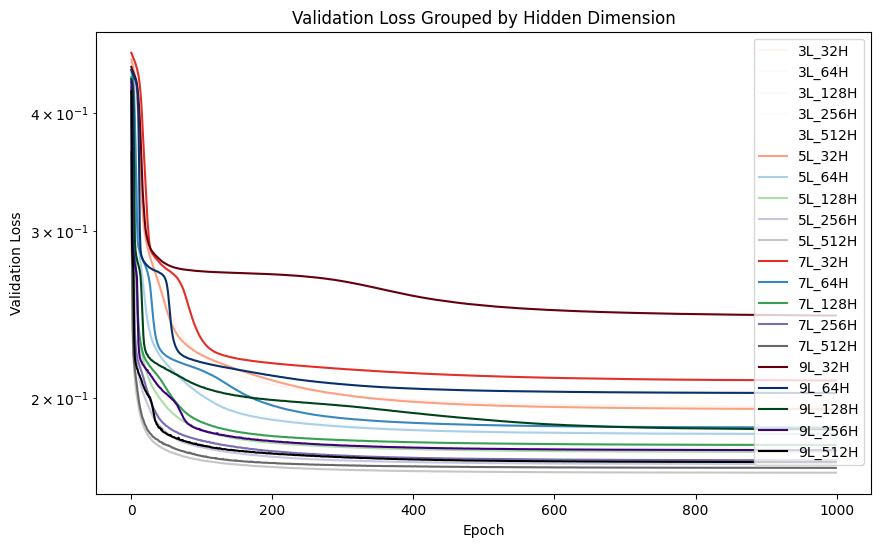

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re

# 색상군 매핑: hidden_dim별 컬러맵 계열 지정
color_families = {
    32: cm.Reds,
    64: cm.Blues,
    128: cm.Greens,
    256: cm.Purples,
    512: cm.Greys
}

# group 내 인덱스 추적
group_counters = {hd: 0 for hd in hidden_dim_list}

# group별 개수 파악
group_counts = {hd: sum(1 for k in results if f"_{hd}H" in k) for hd in hidden_dim_list}

plt.figure(figsize=(10, 6))

for key in results:
    # hidden dim 추출 (예: '3L_128H' → 128)
    match = re.search(r'_(\d+)H', key)
    if match:
        hidden_dim = int(match.group(1))
    else:
        hidden_dim = 0  # fallback

    # 현재 그룹에서 몇 번째 선인지
    idx_in_group = group_counters[hidden_dim]
    num_in_group = group_counts[hidden_dim]
    cmap = color_families.get(hidden_dim, cm.Greys)

    color = cmap(idx_in_group / max(num_in_group - 1, 1))
    group_counters[hidden_dim] += 1

    plt.plot(results[key]['val_loss'], label=key, color=color)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.yscale("log")
plt.title("Validation Loss Grouped by Hidden Dimension")
plt.legend()
plt.show()


In [ ]:
import pickle

# 저장된 실험 결과 불러오기
with open("all_policy_losses.pkl", "rb") as f:
    results = pickle.load(f)

# 요약 비교 테이블 생성
summary = []

for config, data in results.items():
    best_epoch = np.argmin(data["val_loss"])
    summary.append({
        "config": config,
        "best_val_loss": data["val_loss"][best_epoch],
        "tracking": data["val_tracking"][best_epoch],
        "smoothness": data["val_smoothness"][best_epoch],
        "constraint": data["val_constraint"][best_epoch]
    })

# pandas DataFrame으로 정리 및 정렬
import pandas as pd
df = pd.DataFrame(summary)
df_sorted = df.sort_values("best_val_loss")

# 결과 출력
pd.set_option("display.precision", 5)
print(df_sorted)


     config  best_val_loss  tracking  smoothness  constraint
9   5L_512H        0.16656   0.15377     0.00941     0.00338
4   3L_512H        0.16756   0.15412     0.00922     0.00422
14  7L_512H        0.16855   0.15509     0.00925     0.00420
8   5L_256H        0.17010   0.15605     0.00898     0.00507
19  9L_512H        0.17093   0.15768     0.00881     0.00444
13  7L_256H        0.17169   0.15778     0.00873     0.00518
3   3L_256H        0.17174   0.15593     0.00878     0.00703
7   5L_128H        0.17518   0.15885     0.00850     0.00783
18  9L_256H        0.17597   0.16212     0.00830     0.00555
2   3L_128H        0.17660   0.15826     0.00833     0.01001
12  7L_128H        0.17819   0.16206     0.00826     0.00787
6    5L_64H        0.18297   0.16411     0.00782     0.01105
1    3L_64H        0.18354   0.16144     0.00794     0.01417
17  9L_128H        0.18511   0.16824     0.00788     0.00899
11   7L_64H        0.18593   0.16684     0.00788     0.01121
5    5L_32H        0.194

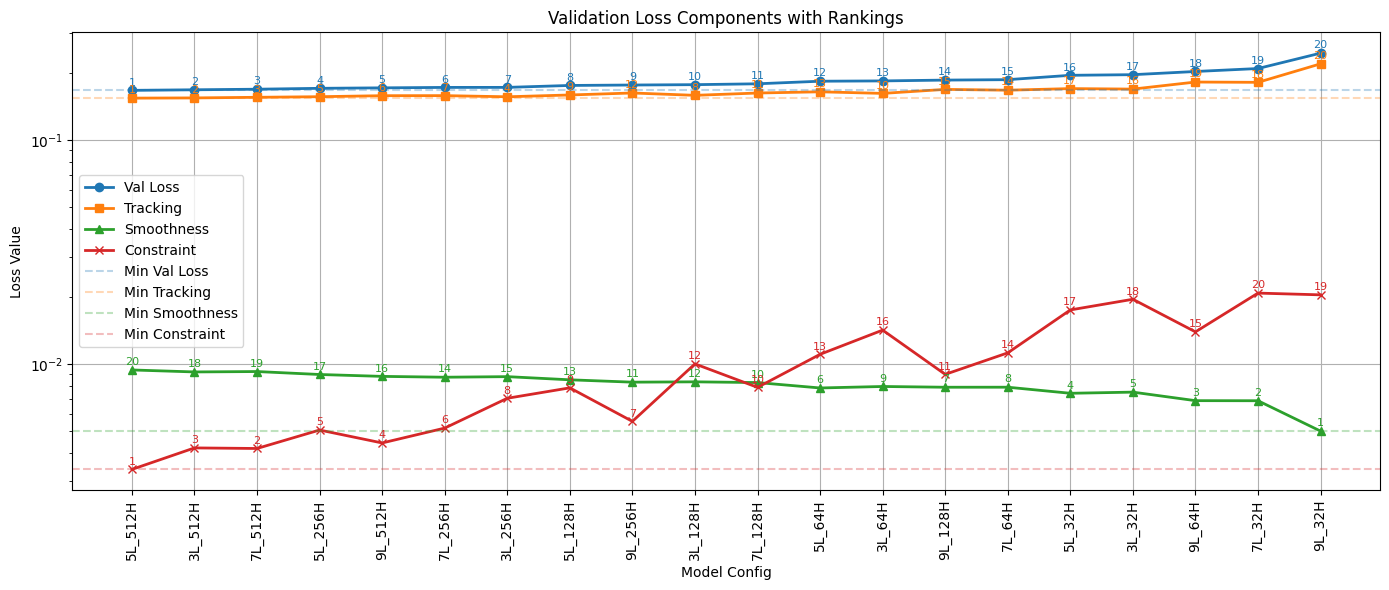

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 정렬 기준은 val_loss지만 순위는 각 항목별로 계산
df_sorted = df.sort_values("best_val_loss").reset_index(drop=True)
configs = df_sorted["config"].tolist()
x = np.arange(len(configs))

# 각 항목별 최소값
min_val_loss = df_sorted["best_val_loss"].min()
min_tracking = df_sorted["tracking"].min()
min_smoothness = df_sorted["smoothness"].min()
min_constraint = df_sorted["constraint"].min()

# 각 항목별 순위 계산 (작을수록 좋음)
rank_val = df_sorted["best_val_loss"].rank(method="min").astype(int)
rank_track = df_sorted["tracking"].rank(method="min").astype(int)
rank_smooth = df_sorted["smoothness"].rank(method="min").astype(int)
rank_const = df_sorted["constraint"].rank(method="min").astype(int)

plt.figure(figsize=(14, 6))

# 각 라인 플롯
plt.plot(x, df_sorted["best_val_loss"], label="Val Loss", marker='o', linewidth=2)
plt.plot(x, df_sorted["tracking"], label="Tracking", marker='s', linewidth=2)
plt.plot(x, df_sorted["smoothness"], label="Smoothness", marker='^', linewidth=2)
plt.plot(x, df_sorted["constraint"], label="Constraint", marker='x', linewidth=2)

# 수평선 (최소값 기준)
plt.axhline(min_val_loss, color='tab:blue', linestyle='--', alpha=0.3, label="Min Val Loss")
plt.axhline(min_tracking, color='tab:orange', linestyle='--', alpha=0.3, label="Min Tracking")
plt.axhline(min_smoothness, color='tab:green', linestyle='--', alpha=0.3, label="Min Smoothness")
plt.axhline(min_constraint, color='tab:red', linestyle='--', alpha=0.3, label="Min Constraint")

# 각 점 위에 순위 표기
for i in x:
    plt.text(i, df_sorted["best_val_loss"][i]*1.05, f"{rank_val[i]}", ha='center', fontsize=8, color='tab:blue')
    plt.text(i, df_sorted["tracking"][i]*1.05, f"{rank_track[i]}", ha='center', fontsize=8, color='tab:orange')
    plt.text(i, df_sorted["smoothness"][i]*1.05, f"{rank_smooth[i]}", ha='center', fontsize=8, color='tab:green')
    plt.text(i, df_sorted["constraint"][i]*1.05, f"{rank_const[i]}", ha='center', fontsize=8, color='tab:red')

# 시각화 설정
plt.xticks(ticks=x, labels=configs, rotation=90)
plt.xlabel("Model Config")
plt.ylabel("Loss Value")
plt.yscale("log")
plt.title("Validation Loss Components with Rankings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
